# ASE calling pipeline

Mostly based on Yanyu's work in 2017. The pipeline aligns `fastq` sequences to `bam` using [`STAR`](https://github.com/alexdobin/STAR/blob/master/doc/STARmanual.pdf), then adjust the mapping via [`WASP`](https://github.com/bmvdgeijn/WASP) to account for allele specificity, and finally call genotype and ASE via [`QuASAR`](https://github.com/piquelab/QuASAR).

## Overview of procedure

1. Gather require resources
2. Align reads to genome
3. Remove biased reads
4. Genotype and ASE calling

The pipeline is implemented in SoS as displayed in the rest of this SoS notebook. The pipeline can be executed from this notebook directly on local or remote computer (with caveats see below). For more information see [SoS website](https://github.com/vatlab/SOS).

- Some NGS software used are loaded from [online `docker` images](https://hub.docker.com/u/gaow). This is me being lazy to avoid installing these softwares on a local computer (which should not take much time anyways). But some cluster system, such as UChicago RCC, does not support `docker`. Also here I did not configure cluster job queues with `task` option. So this notebook is intended to run on a local workstation as is, though involves minimal changes to get it work distributively on cluster, given required software are installed there.
- `bedtools` is needed by `QuASAR` thus cannot be loaded from a docker image. It is installed from standard software repo (Debian's `apt-get install bedtools`).


To run the pipeline:

```
nb=analysis/20180311_ASE_Calling_WASP_QuASAR.ipynb
sos run $nb hg19_reference
sos run $nb obtain_samples
sos run $nb default
```

You can use `-s force` to force redo everything, or `-s build` to skip existing results merely by file name.

### Difference from Yanyu's version

Other than using a formal pipeline tool, differences are:

1. Here samples are paired end reads -- this led to minor differences in `STAR` and `WASP` command parameters. I used a global boolean parameter `is_paired_end` to control for it.
2. No techinical replicates in this problem -- skipped Yanyu's steps of dealing with (merging / spliting) technical replicates before and after `quasar`.

### Lessons learned: a retrospective view

A list of cautions learned from running the pipeline:

1. The `STAR` aligner is fast (compared to `tophat`) but requires over 30GB of memory. A desktop with 32GB of memory will not work for the `STAR` steps. I actually had to use a 64GB RAM desktop. To save memory, have to use sparse mode for `STAR` [with caveats pointed here](https://groups.google.com/forum/#!topic/rna-star/7FhgJodsLSQ), which works for under 16GB memory. This is implemented by global parameter `sparse_star = True`.

    - Sparse mode for STAR does not work well as the normal mode. The size of align_1 step bam file is obviously smaller than normal mode.

2. `STAR`, when it fails (memory or not), will fail silently.
3. Preparation of `STAR` database takes long time, but it is portable as long as one changes the absolute path in `genomeParameters.txt` to relative (ie, remove all the directories from file names only keep the basename). This is what I did. So the resource prepared by `[star]` workflow (below) can be copied to use in other machines.

### Settings and default workflow

In [ ]:
[global]
cwd = path('~/Documents/m6A/Data/ASE')
parameter: ncpu = 20
# Resource files
resource_dir = f"{cwd:a}/hg19"
ref_fa = "hg19.fa"
ref_gtf = 'Homo_sapiens.GRCh38.91.gtf.gz'
wasp_dir = path(f"/opt/WASP/mapping")
samtools_snp_list = f"{resource_dir}/020717_filtered_maf5_blacklist.final.bed"
# Sample files
sample_dir = f"{cwd:a}/samples"
paired_end = True
sparse_star = False
from collections import OrderedDict
## A list of sample names (keys) and their corresponding FASTQ files (values)
# samples = OrderedDict({'ENCLB279NMT': ['ENCFF824TZM', 'ENCFF176JNE'],
#                        'IGF2BP2': ['ENCFF307AUO', 'ENCFF563WIX'], 
#                        'FTO': ['ENCFF374PSI', 'ENCFF877URW'],
#                        'HNRNPC': ['ENCFF035QUK', 'ENCFF065BIC']})
samples = OrderedDict({"IGF2BP2": ['ENCFF307AUO', 'ENCFF563WIX'], 
                       "FTO": ['ENCFF374PSI', 'ENCFF877URW'], 
                       "HNRNPC": ['ENCFF035QUK', 'ENCFF065BIC']})
fastq = paths([[f"{sample_dir}/{s}/{q}.fastq.gz" for q in samples[s]] for s in samples])

In [ ]:
[default]
sos_run('align+call')

## Resource preparation

### hg19 human reference data

Obtain `hg19.fa` and `Homo_sapiens.GRCh38.91.gtf.gz`.

In [ ]:
[hg19_reference_1 (download)]
# Download `hg19.2bit` and `twoBitToFa` from {ucsc_url}
ucsc_url = "http://hgdownload.cse.ucsc.edu"
output: f"{resource_dir}/hg19.2bit", f"{resource_dir}/twoBitToFa"
download: dest_dir = resource_dir, expand = True
    {ucsc_url}/goldenPath/hg19/bigZips/hg19.2bit
    {ucsc_url}/admin/exe/linux.x86_64/twoBitToFa

[hg19_reference_2 (decompress hg19.fa)]
# Use `twoBitToFa` to extract `hg19.fa` from `hg19.2bit`
output: f"{resource_dir}/{ref_fa}"
bash: expand = True
    chmod +x {_input[1]}
    {_input[1]} {_input[0]} {_output}

[hg19_reference_3 (gene annotations)]
# Download `Homo_sapiens.GRCh38.91.gtf.gz` from Ensembl
# https://useast.ensembl.org/info/data/ftp/index.html
ensembl_ftp = 'ftp://ftp.ensembl.org/pub/release-91/gtf/homo_sapiens/'
output: f"{resource_dir}/{ref_gtf}"
download: dest_dir = resource_dir, expand = True
    {ensembl_ftp}/{ref_gtf}

### Software tools

In [ ]:
[star]
# Quite time & resource consuming (3hrs, 32GB memory if sparse_star is False)
depends: Py_Module('docker')
output: f"{resource_dir}/genomeParameters.txt"
run: workdir = f'{cwd:a}', docker_image = 'gaow/debian-ngs', expand=True
     STAR --runMode genomeGenerate \
        --genomeDir {resource_dir} \
        --genomeFastaFiles {resource_dir}/{ref_fa} \
        --sjdbGTFtagExonParentTranscript {resource_dir}/{ref_gtf} \
        --runThreadN {ncpu} {'--genomeSAsparseD 2' if sparse_star else ''}

[quasar]
depends: R_library("QuASAR@piquelab/QuASAR")
output: f'{resource_dir}/convertPileupToQuasar.R'
download: dest_file = f'{resource_dir}/convertPileupToQuasar.R'
    https://raw.githubusercontent.com/piquelab/QuASAR/master/scripts/convertPileupToQuasar.R
run: expand = True
    perl -pi.bak -e "s/less/zcat/" {_output}

## Get samples

FIXME: add description -- what are these samples?

In [ ]:
[obtain_samples]
# Download samples from ENCODE
# https://www.encodeproject.org/experiments/ENCSR384KAN/
encode_url = 'https://www.encodeproject.org/files'
input: for_each = 'fastq', concurrent = True
output: fastq, group_by = 1
download: dest_dir = f'{_fastq:d}', expand = True
    {encode_url}/{_fastq:bnn}/@@download/{_fastq:b}

## Alignment

(workflow chart prepared by Yanyu)

> ../writeup/wasp.png (109.4 KiB):

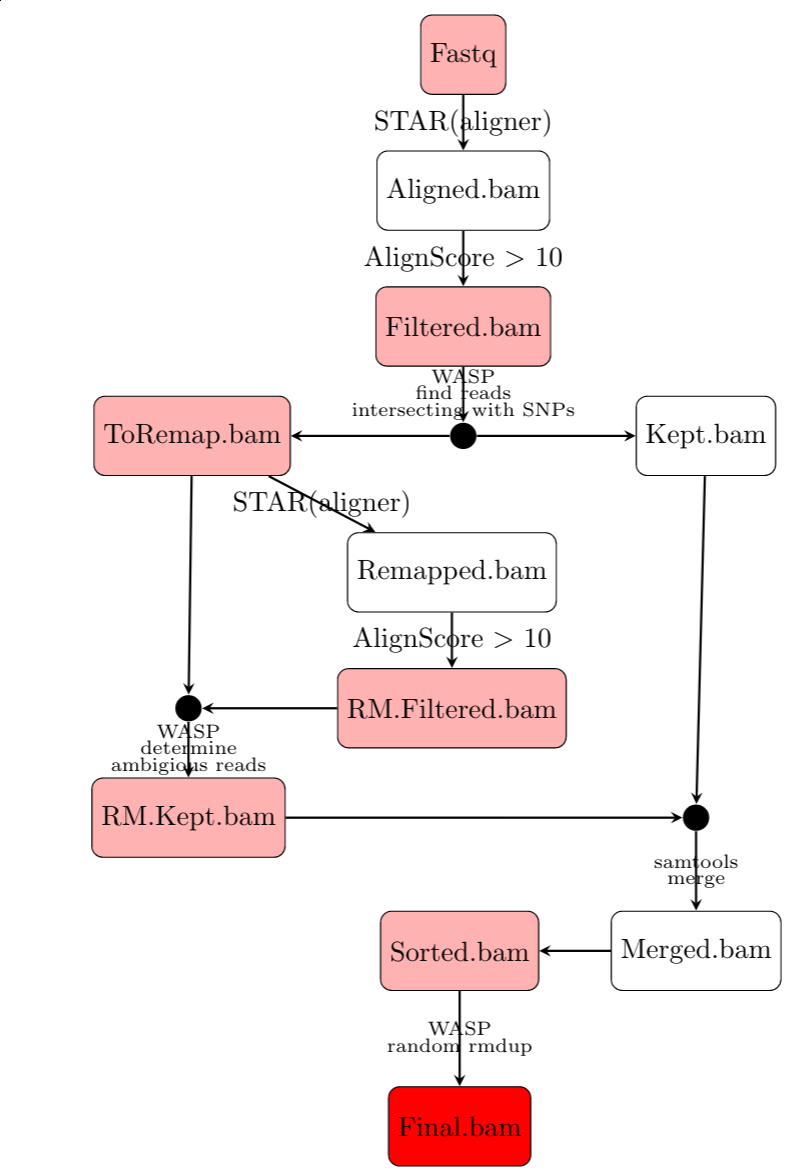

In [2]:
%preview ../writeup/wasp.png -n

### Prefiltering alignment

Align with `STAR`, followd by `samtools` to remove reads with quality less than given cutoff.

In [ ]:
[align_1 (STAR prefiltering alignment)]
parameter: qual_cutoff = 10
depends: sos_step('star')
input: fastq, group_by = 2, concurrent = True
output: [f"{sample_dir}/{x}.qual{qual_cutoff}.bam" for x in samples], group_by = 1
run: workdir = f'{cwd:a}', docker_image = 'gaow/debian-ngs', expand=True
    STAR --genomeDir {resource_dir} \
        --readFilesIn {_input[0]} {_input[1]} \
        --readFilesCommand zcat \
        --runThreadN {ncpu} --outStd BAM_SortedByCoordinate \
        --outSAMtype BAM SortedByCoordinate \
        --sjdbGTFtagExonParentTranscript {resource_dir}/{ref_gtf} |
    samtools view -bq {qual_cutoff} > {_output}

### WASP-informed remap

Remap reads after [`WASP`](https://github.com/bmvdgeijn/WASP/tree/master/mapping) adjustment. `WASP` uses pre-defined list of SNPs and removes bias caused by them. The list was generated by Yanyu using 1k genome SNP in VCF format with MAF filter as input to `WASP/mapping/extract_vcf_snps.sh` command. Here I just take this pre-compiled list from Yanyu.

In [ ]:
[align_2 (WASP intersecting SNP): shared = {'wasp_split': 'step_output'}]
# WASP finding unbiased reads intersecting with SNP
input: group_by = 1, concurrent = True
output: f"{_input:n}.remap.fq1.gz", f"{_input:n}.remap.fq2.gz", f"{_input:n}.to.remap.bam", f"{_input:n}.keep.bam"
bash: workdir = f'{cwd:a}', docker_image = 'gaow/wasp', volumes = [f'{resource_dir}/wasp_snp_list:{wasp_dir:d}/examples'], expand = True
    python {wasp_dir}/find_intersecting_snps.py {_input} \
        --snp_dir {wasp_dir:d}/examples \
        --is_sorted {'--is_paired_end' if paired_end else ''}

[align_3 (STAR post alignment)]
# Align WASP remap with STAR
# Followd by samtools remove reads with quality less than {qual_cutoff}
parameter: qual_cutoff = 10
input: group_by = 4, pattern = '{name}.{qual}.remap.{ext}', concurrent = True
output: expand_pattern(f'{_name[0]}.remapped.qual{qual_cutoff}.bam')
run: workdir = f'{cwd:a}', docker_image = 'gaow/debian-ngs', expand=True
    STAR --genomeDir {resource_dir} \
        --readFilesIn {_input[0]} {_input[1]} \
        --readFilesCommand zcat \
        --runThreadN {ncpu} --outStd BAM_SortedByCoordinate \
        --outSAMtype BAM SortedByCoordinate \
        --sjdbGTFtagExonParentTranscript {resource_dir}/{ref_gtf} |
    samtools view -bq {qual_cutoff} > {_output}

[align_4 (WASP remove ambiguously mapped reads)]
to_remap = paths([wasp_split[i:i+4][2] for i in range(0, len(wasp_split), 4)])
input: group_by = 1, paired_with = 'to_remap', pattern = '{name}.remapped.{ext}', concurrent = True
output: expand_pattern(f'{_name[0]}.keep_remapped.{_ext[0]}')
bash: workdir = f'{cwd:a}', docker_image = 'gaow/wasp', expand=True, stderr = f'{_output:n}.log'
    python {wasp_dir}/filter_remapped_reads.py {_to_remap} {_input} {_output}

[align_5 (Merge WASP adjusted and originally kept BAM)]
kept = paths([wasp_split[i:i+4][3] for i in range(0, len(wasp_split), 4)])
input: group_by = 1, paired_with = 'kept', pattern = '{name}.keep_remapped.{ext}', concurrent = True
output: expand_pattern(f'{_name[0]}.wasp_remapped.{_ext[0]}')
run: workdir = f'{cwd:a}', docker_image = 'gaow/debian-ngs', expand=True
    samtools merge - {_input} {_kept} | samtools sort -o {_output}
    samtools index {_output}

[align_6 (WASP remove duplicate reads )]
input: group_by = 1, pattern = '{name}.bam', concurrent = True
output: expand_pattern(f'{_name[0]}.dedup.bam')
bash: workdir = f'{cwd:a}', docker_image = 'gaow/wasp', expand=True, stderr = f'{_output:n}.log'
    python {wasp_dir}/{'rmdup_pe.py' if paired_end else 'rmdup.py'} {_input} {_output}

## Genotype and ASE calling

### Pre-`QuASAR` calling

This step extracts count information from BAM file based on SNP list and prepare it into `QuASAR` input format, as instructed on [`QuASAR`](https://github.com/piquelab/QuASAR/blob/2b8bf4cb5c303c7c87a444851764678b67e57f3c/README.md) documentation. Here we need the list of SNPs used in BED format, and reference genome `fasta` file. Yanyu has previously prepared this BED file. Here I just grab and use it.

**Note: the `awk` command from Yanyu is different from the instruction above; yet using the above command there is little variants left ...**

In [ ]:
[call_1 (samtools pileup)]
# A standard samtools mpileup call
input: group_by = 1, pattern = '{name}.bam', concurrent = True
output: expand_pattern(f'{_name[0]}.pileup.gz')
run: workdir = f'{cwd:a}', docker_image = 'gaow/debian-ngs', expand=True
    samtools sort {_input} | samtools mpileup -f {resource_dir}/{ref_fa} -l {samtools_snp_list} - | gzip > {_output}

[call_2 (awk & bedtools filter pileup)]
# Remove bad pileup (indels) and intersect only with list of SNPs provided
input: group_by = 1, pattern = '{name}.pileup.gz', concurrent = True
output: expand_pattern(f'{_name[0]}.pileup.bed.gz')
run: workdir = f'{cwd:a}', docker_image = 'gaow/debian-ngs', expand = '${ }'
    # less input.pileup.gz | awk -v OFS='\t' '{ if ($4>0 && $5 !~ /[^\^][<>]/ && $5 !~ /\+[0-9]+[ACGTNacgtn]+/ && $5 !~ /-[0-9]+[ACGTNacgtn]+/ && $5 !~ /[^\^]\*/) print $1,$2-1,$2,$3,$4,$5,$6}' | sortBed -i stdin | intersectBed -a stdin -b snps.af.bed -wo | cut -f 1-7,11-14 | gzip > input.pileup.bed.gz
    zcat ${_input} | \
    awk -v OFS='\t' '{ if ($4>0 && $5 !~ /\+[0-9]+[ACGTNacgtn]+/ && $5 !~ /-[0-9]+[ACGTNacgtn]+/ && $5 !~ /[^\^]\*/) print $1,$2-1,$2,$3,$4,$5,$6}' | \
    sortBed -i stdin | intersectBed -a stdin -b ${samtools_snp_list} -wo | \
    cut -f 1-7,11-14 | gzip > ${_output}

[call_3 (convert to quasar format)]
input: group_by = 1, pattern = '{name}.pileup.bed.gz', concurrent = True
output: expand_pattern(f'{_name[0]}.quasar.in.gz')
bash: workdir = f'{_input:d}', expand = True, stdout = f'{_output:n}.log'
    R --slave --args {_input} < {resource_dir}/convertPileupToQuasar.R

### Genotyping and ASE inference

The `QuASAR` [example workflow](https://github.com/piquelab/QuASAR/blob/2b8bf4cb5c303c7c87a444851764678b67e57f3c/scripts/exampleWorkflow.R) assumes multiple replicates per sample; so is Yanyu's 2017 analysis. Here we only have one replicate per sample.

In [ ]:
[call_4 (quasar genotyping and ASE)]
depends: sos_step('quasar')
input: group_by = 1, concurrent = True
output: f"{_input:nn}.genotype.tsv", f"{_input:nn}.ase.rds"
R: workdir = f'{cwd:a}', expand = '${ }', stdout = f'{_input:nn}.out.log'
    library('QuASAR')
    ase.dat <- UnionExtractFields(${_input:r}, combine=T)
    ase.dat.gt <- PrepForGenotyping(ase.dat, min.coverage=5)
    sample.names <- colnames(ase.dat.gt$ref)
    ase.joint <- fitAseNullMulti(as.matrix(ase.dat.gt$ref), as.matrix(ase.dat.gt$alt), log.gmat=log(ase.dat.gt$gmat))
    out_gt <- data.frame(ase.dat.gt$annotations[, -5], map=ase.joint$gt)
    out_ase <- aseInference(gts=ase.joint$gt, eps.vect=ase.joint$eps, priors=ase.dat.gt$gmat, ref.mat=as.matrix(ase.dat.gt$ref), alt.mat=as.matrix(ase.dat.gt$alt), 
                            min.cov=10, sample.names=sample.names, annos=ase.dat.gt$annotations)
    write.table(out_gt, file=${_output[0]:r}, row.names=FALSE, col.names=FALSE, quote=FALSE, sep="\t")
    saveRDS(out_ase, ${_output[1]:r})

The output of the alignment and calling pipelines are `*.genotype.tsv` for genotypes and `*.ase.rds` for ASE.